# A Distributional Code for Value

This notebook replicates a subset of the results presented in [A distributional code for value in dopamine- based reinforcement learning](https://www.nature.com/articles/s41586-019-1924-6) (Dabney et al., 2019). 

In particular, the notebook compares the distributions of value estimates learned in a variable magnitude reward task between a classical TD learning algorithm, and an algorithm which uses a distribution of "optimistic" and "pessimistic" cells.

In [1]:
# Uncomment below lines and run this cell to install neuronav and requirements for colab.

#!git clone https://github.com/awjuliani/neuro-nav
#!pip install ./neuro-nav[experiments_remote]

In [2]:
from neuronav.envs.graph_env import GraphEnv
from neuronav.agents.dist_agents import DistQ
from neuronav.envs.graph_structures import GraphStructure
from neuronav.utils import run_episode
import matplotlib.pyplot as plt
import numpy as np

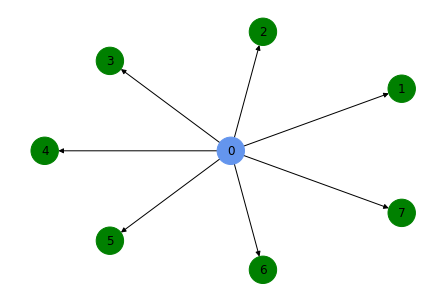

In [3]:
env = GraphEnv(graph_structure=GraphStructure.variable_magnitude)
obs = env.reset()
env.render()

In [4]:
def plot_rpes(rpes, title):
    juice_levels = [0.1, 0.3, 1.2, 2.5, 5, 10, 20]
    for i in range(len(rpes)):
        plt.scatter(
            rpes[i, :],
            np.arange(0, rpes.shape[-1]),
            s=10,
            label=juice_levels[i],
        )
    plt.vlines(x=0, ymin=0, ymax=rpes.shape[-1], colors="gray", ls=":", lw=2)
    plt.legend(title="Juice Level")
    plt.ylabel("Cell Number")
    plt.xlabel("RPE (Normalized)")
    plt.title(title)


def plot_cell_estimates(value_estimates):
    plt.figure(figsize=(20, 5))
    plt.bar(np.arange(0, len(value_estimates)), value_estimates)
    plt.xlabel("Cell Number")
    plt.ylabel("Value Estimate")
    plt.title("Call Value Estimates")


def get_rpes(dist):
    rewards = env.reward_nodes[1:]
    lr_floor = 0.2

    rpes = []
    lrp = lr_floor + agent.lrs_pos
    lrn = lr_floor + agent.lrs_neg
    for reward in rewards:
        q_error = reward - dist
        qep = (q_error > 0.0) * 1.0
        rpe = (lrp * qep + lrn * (1 - qep)) * q_error
        rpes.append(rpe)
    rpes = np.stack(rpes)

    sort_ids = np.argsort(dist)
    sorted_rpes = rpes[:, sort_ids]
    sorted_rpes /= sorted_rpes.std(0, keepdims=True)
    sorted_rpes = sorted_rpes[:, ::5]
    return sorted_rpes

## Distributional RL

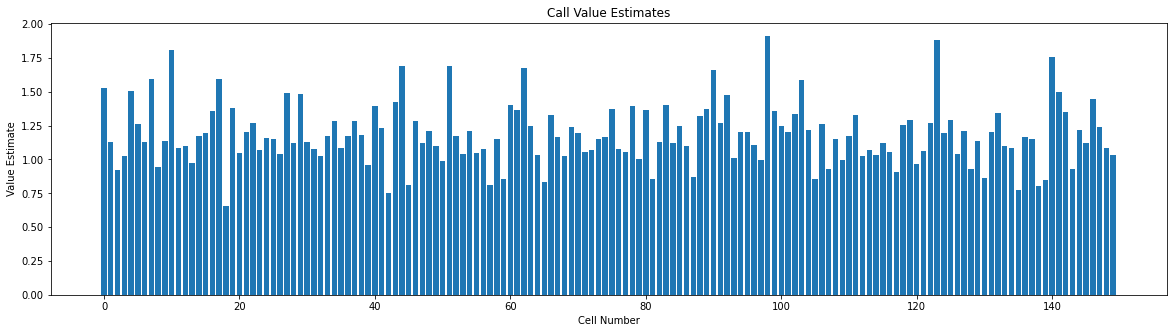

In [5]:
num_episodes = 25000

agent = DistQ(env.state_size, env.action_space.n, dist_cells=150, mirror=False)
total_steps = []
for i in range(num_episodes):
    agent, steps = run_episode(env, agent, max_steps=1)
    total_steps.append(steps)

dist = agent.Q[0, 0]
plot_cell_estimates(dist)

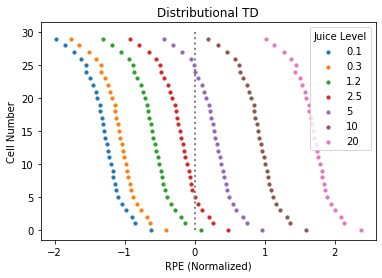

In [6]:
rpes = get_rpes(dist)
plot_rpes(rpes, "Distributional TD")

### Non-Distributional RL

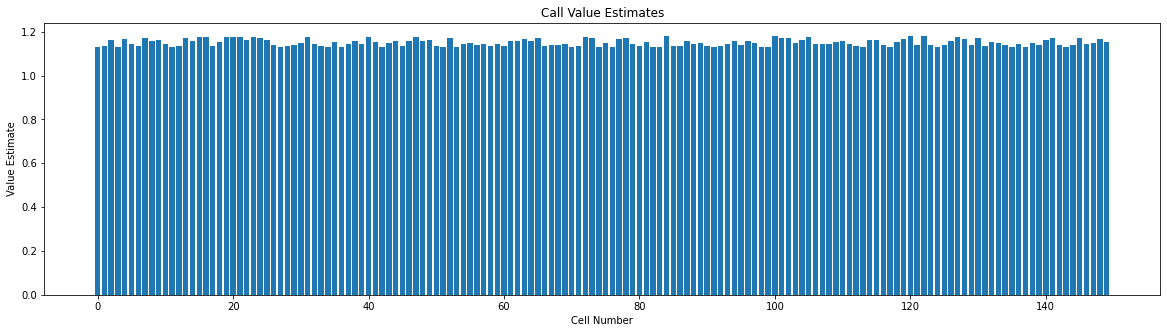

In [7]:
num_episodes = 25000

agent = DistQ(env.state_size, env.action_space.n, dist_cells=150, mirror=True)
total_steps = []
for i in range(num_episodes):
    agent, steps = run_episode(env, agent, max_steps=1)
    total_steps.append(steps)

dist = agent.Q[0, 0]
plot_cell_estimates(dist)

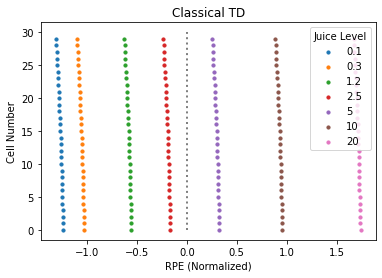

In [8]:
rpes = get_rpes(dist)
plot_rpes(rpes, "Classical TD")